Neka je $M$ matrica čiji su retci cijene u razdoblju za koje određujemo težinski prosjek, $\mathbf{w}$ vektor težinskih koeficijenata, $\mathbf{c}$ vektor svih cijena u promatranom vremenskom otvoru širine $p$. Zadatak se svodi na sljedeći optimizacijski problem:

$$
  \min_{\mathbf{w}}\quad acc=\frac{1}{p}||M\mathbf{w}-\mathbf{c}||_1\\

  \textrm{s.t.}\quad smoo\leq smoo_0
$$

gdje je $smoo$ mjera glatkoće opisana u radu, a $smoo_0$ glatkoća prvog promatranog vremenskog otvora. Fukcija koju minimiziramo zovemo točnost.

In [33]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [34]:
#FUNKCIJA OPTIMIRANJA
def opt(path, n, p):
    f=open(path)
    lmbda = cp.Variable(100)
    prices = np.array([])
    c = np.array([])
    C_matrix = np.array([])
    C2 = np.array([])
    C1 = np.array([])
    C0 = np.array([])
    w = cp.Variable((n))
    w1 = np.ones(n)/n
    MA_list = np.array([])
    smoo_0 = 0
    k=0

    for i in range(n + p - 1 + k):
        if i>=k:
            prices = np.append(prices, float(f.readline().split(",")[4]))  # .split(",")[4]
        else:
            f.readline()
    for i in range(p):
        c = np.append(c, prices[n - 1 + i])
        C_matrix = np.append(C_matrix, prices[i:i + n])
        if i >= 2 and i <= p - 1:
            C2 = np.append(C2, prices[i:i + n])
        if i >= 1 and i <= p - 2:
            C1 = np.append(C1, prices[i:i + n])
        if i >= 0 and i <= p - 3:
            C0 = np.append(C0, prices[i:i + n])
    C_matrix = np.reshape(C_matrix, (p, n))
    C2 = np.reshape(C2, (p - 2, n))
    C1 = np.reshape(C1, (p - 2, n))
    C0 = np.reshape(C0, (p - 2, n))
    dC = (C2 - 2 * C1 + C0)
    error = cp.norm((C_matrix @ w) - c, 1) / p  # conv
    smoo = cp.norm(dC @ w, 1) / (p - 2)  # conv

    for i in range(n - 1, p + n - 1):
        MA_list = np.append(MA_list, np.dot(prices[i - n + 1:i + 1], w1))

    for i in range(2, len(MA_list)):
        smoo_0 += abs(MA_list[i] - 2 * MA_list[i - 1] + MA_list[i - 2])

    smoo_0 /= (p - 2)
    constr = [smoo <= smoo_0]
    prob = cp.Problem(cp.Minimize(error),constr)
    prob.solve()
    return w.value

Odabiremo putanju datoteke i parametre optimizacije, n i p. n je broj prethodnih cijena čiji težinski prosjek računamo, a p je širina vremenskog otvora na kojem optimiramo. Nakon toga pokrećemo optimizaciju.

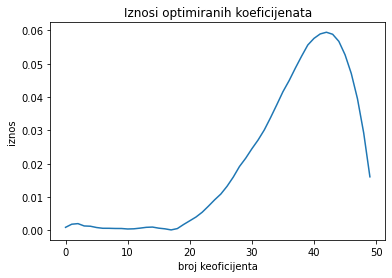

In [35]:
#datoteke na gitu; treba podesiti putanju
path="C:\\Users\\hrvoj\\OneDrive\\Radna površina\LAFRA\\futures-active_adjusted_1min_qucz81\\MBT_continuous_adjusted_1min.txt"
n=50
p=7200

w=opt(path,n,p)

plt.plot(np.linspace(0,len(w)-1,len(w)),w)
plt.xlabel("broj keoficijenta")
plt.ylabel("iznos")
plt.title("Iznosi optimiranih koeficijenata")
plt.show()

Usporedimo kretanja funkcije $acc$ kroz vremenske otvore kod čistog usrednjavanja (SMA) i primjenom dobivenih koeficijenata.

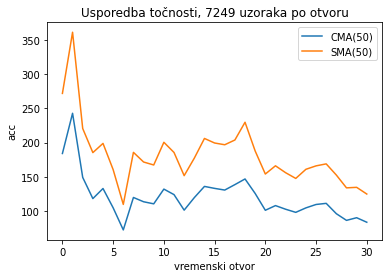

In [36]:
prices = open(path).readlines()
w1=np.ones(n)/n #koeficijenti za aritmeticku sredinu (1/n)
error = np.array([])
error1 = np.array([])

for i in range(len(prices)):
    prices[i]=float(prices[i].split(",")[4])

for i in range(len(prices)//(n+p-1)):
    c=prices[i*(n+p-1):(i+1)*(n-1+p)]
    cma=np.array([])
    sma=np.array([])
    for j in range(n,n+p):
        cma=np.append(cma,np.dot(c[j-n:j],w))
        sma=np.append(sma,np.dot(c[j-n:j],w1))
    error=np.append(error,np.linalg.norm(cma-c[n-1:],1)/p)
    error1=np.append(error1,np.linalg.norm(sma-c[n-1:],1)/p)
plt.plot(np.linspace(0,len(prices)//(n+p-1)-1,len(prices)//(n+p-1)),error,label="CMA(%d)" % (n))
plt.plot(np.linspace(0,len(prices)//(n+p-1)-1,len(prices)//(n+p-1)),error1,label="SMA(%d)" % (n))
plt.legend()
plt.title("Usporedba točnosti, %d uzoraka po otvoru" % (n+p-1))
plt.xlabel("vremenski otvor")
plt.ylabel("acc")
plt.show()

Iz grafa su vidljive dvije stvari:
1. koeficijenti dobiveni optimizacijom su bolji u smislu manje pogreške od čistog prosjeka,
2. filter nije vremenski stabilan, tj. $acc$ mijenja iznos kroz nove vremenske otvore.

Dalje, rezultati optimiranja koefcijenata u istom problemu kao na početku, ali na drugom vremenskom nizu daje vrlo slične rezultate. Provest ćemo optimiranje na drugoj datoteci.

In [37]:
path2="C:\\Users\\hrvoj\\OneDrive\\Radna površina\LAFRA\\futures-active_adjusted_1min_qucz81\\XC_continuous_adjusted_1min.txt"
w2=opt(path2,n,p)
plt.plot(np.linspace(0,n-1,n),w2)
plt.xlabel("broj koeficijenta")
plt.ylabel("iznos")
plt.title("Optimiranje druge datoteke")
plt.show()

KeyboardInterrupt: 

Kao što vidimo, novi se koeficijenti ne razlikuju toliko od onih iz prvog optimiranja. Provjerimo mijenjanje $acc$ kroz vremenske otvore na novoj datoteci.

In [ ]:
prices = open(path2).readlines()
error = np.array([])
error1 = np.array([])
error2 = np.array([])

for i in range(len(prices)):
    prices[i]=float(prices[i].split(",")[4])

for i in range(len(prices)//(n+p-1)):
    c=prices[i*(n+p-1):(i+1)*(n-1+p)]
    cma=np.array([])
    sma=np.array([])
    cma2=np.array([])
    for j in range(n,n+p):
        cma=np.append(cma,np.dot(c[j-n:j],w))
        cma2=np.append(cma2,np.dot(c[j-n:j],w2))
        sma=np.append(sma,np.dot(c[j-n:j],w1))
    error=np.append(error,np.linalg.norm(cma-c[n-1:],1)/p)
    error1=np.append(error1,np.linalg.norm(sma-c[n-1:],1)/p)
    error2=np.append(error2,np.linalg.norm(cma2-c[n-1:],1)/p)
plt.plot(np.linspace(0,len(prices)//(n+p-1)-1,len(prices)//(n+p-1)),error,label="CMA(%d), prva optimizacija" % (n))
plt.plot(np.linspace(0,len(prices)//(n+p-1)-1,len(prices)//(n+p-1)),error2,label="CMA(%d), druga optimizacija" % (n))
plt.plot(np.linspace(0,len(prices)//(n+p-1)-1,len(prices)//(n+p-1)),error1,label="SMA(%d)" % (n))
plt.legend()
plt.title("Usporedba točnosti, %d uzoraka po otvoru" % (n+p-1))
plt.xlabel("vremenski otvor")
plt.ylabel("acc")
plt.show()

Vidljivo je da koeficijenti iz dvije različite optimizacije daju vrlo slične rezultate. Dakle, filter možemo smatrati prostorno stabilnim (optimirani se koeficijenti ne razlikuju previše od niza do niza).

Odredimo mu sad amplitudno i fazno-frekvencijsku karakteristiku. Još treba reći da je ovo FIR (Finite impulse response) filter čiji je impulsni odziv dan grafom.

In [ ]:
plt.plot(np.linspace(0,n-1,n),w[::-1],"o")
plt.xlabel("n")
plt.ylabel("h[n]")
plt.show()

Iz impulsnog odziva $h[n]$ računamo Fourierovu transformaciju
$$
    H(\Omega)=\sum_{k=0}^{n-1}h[k]e^{-jk\Omega}
$$

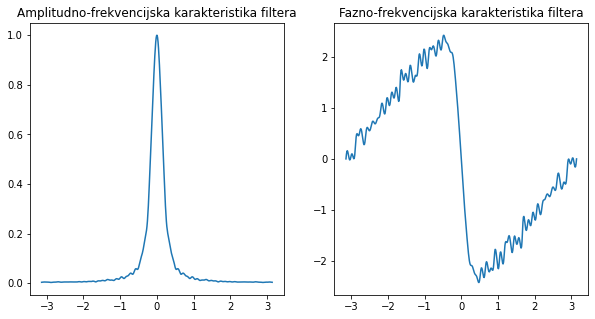

In [42]:
h=w[::-1]
omega=np.linspace(-np.pi,np.pi,500)
H=np.array([])
for i in omega:
    s=0
    for k in range(len(h)):
        s += h[k]*(np.cos(k*i)-1j*np.sin(k*i))
    H=np.append(H,s)

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.plot(omega,abs(H))
ax1.title.set_text("Amplitudno-frekvencijska karakteristika filtera")
#ax1.set_xlabel("Ω [rad/s]")
#ax1.set_ylabel("|H(jΩ)|")

ax2.plot(omega,np.angle(H))
ax2.title.set_text("Fazno-frekvencijska karakteristika filtera")
#ax2.set_xlabel("Ω [rad/s]")
#ax2.set_ylabel("∠H(jΩ)")
plt.show()

Kao što je za očekivati, vidimo da je filter niskopropusni. Vidimo da je gušenje viših frekvencija izraženije nego kod običnog usrednjavanja.

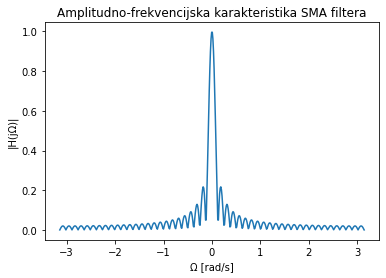

In [43]:
h=w1[::-1]
omega=np.linspace(-np.pi,np.pi,500)
H=np.array([])
for i in omega:
    s=0
    for k in range(len(h)):
        s += h[k]*(np.cos(k*i)-1j*np.sin(k*i))
    H=np.append(H,s)

plt.plot(omega,abs(H))
plt.title("Amplitudno-frekvencijska karakteristika SMA filtera")
plt.xlabel("Ω [rad/s]")
plt.ylabel("|H(jΩ)|")
plt.show()